<a href="https://colab.research.google.com/github/ramiltaief/PRJT_Face_recognition/blob/main/Copie_de_Project_LETAIEF_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Réalisé par Rami Letaief**

#Principles of Face recognition

In a nutshell, a face recognition system extracts features from an input face image and compares them to the features of labeled faces in a database. Comparison is based on a feature similarity metric and the label of the most similar database entry is used to label the input image. If the similarity value is below a certain threshold the input image is labeled as *unknown*. Comparing two face images to determine if they show the same person is known as face verification.

This notebook follows the architecture described in [this scientific article](https://arxiv.org/abs/1503.03832) (2015). Notice that it is similar to the algorithm used by the FaceID of the iPhone X.

![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/im3L.jpg)

Source: http://www.robots.ox.ac.uk/~vgg/data/celebrity_together/

Russell Crowe is labelled as "unknown": the face recognition process did not recognize him. Humans are still better than computers at recognizing each other ;)

#Face recognition is composed of several steps



##Face detection and alignment: 5 points
Detect, transform, and crop faces on the input image. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.

Original image: ![Texte alternatif…](http://vis-www.cs.umass.edu/lfw/images/Jacques_Chirac/Jacques_Chirac_0001.jpg) 
Aligned image: after alignment, the eyes MUST form an horizontal line: ![Texte alternatif…](http://vis-www.cs.umass.edu/lfw/images_deepfunneled/Jacques_Chirac/Jacques_Chirac_0001.jpg)

In order to align the image of the face, we have to:
1.   Detect the face. If we detect several faces, we have to treat them separately.

![Texte alternatif…](https://www.pyimagesearch.com/wp-content/uploads/2018/03/faster_facial_landmarks_animation.gif)

2.   Detect the alignment of the face. It implies that the person must face the camera, because we need to see the "keypoints" on the face, especially the eyes.

![Texte alternatif…](http://1.bp.blogspot.com/-FtyIjfFokzQ/U__h1sAoEEI/AAAAAAAAAR0/URuVhX9cR-E/s1600/landmarked_face2.png)

3.   Rotate, crop in order to extract only the face, resize the image to 96x96 pixels in order to feed into the CNN

![Texte alternatif…](https://github.com/cmusatyalab/openface/blob/master/images/summary.jpg?raw=true)

**Of course, the algorithms below work ONLY if the persons are facing the camera, otherwise the face detector won't be able to detect keypoints, neither to extract the face, and of course identify it.**


###Download the 68-point facial landmark detector

Here, we use [Dlib](http://dlib.net/) for face detection. As explained [here](https://www.pyimagesearch.com/2018/04/02/faster-facial-landmark-detector-with-dlib/), the 68-point detector is more accurate than the 5-point detector, but 8-10% slower, and much heavier: 9.2Mb vs 99.7Mb. As shown by the red points, the 68-point is used on the top image, and the 5-point detector is used on the bottom image.

![Texte alternatif…](https://www.pyimagesearch.com/wp-content/uploads/2018/03/faster_facial_landmarks_5_vs_68.jpg)

In our case, we have enough space to store the 68-points model, and speed is not a concern, but you might have to chose for your own use case.
We download the 68-points model and save it to 'models/landmarks.dat'

In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

We install dlib. It might take a while, because the Python API wraps a C++ library, which must be compiled by cmake.

In [ ]:
!apt update
!apt install -y cmake
!pip install dlib

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:12 https://developer.download.nvidia.com/compute/machine-learning/repos

###Code the face alignment: 2 points

The 68-points model of dlib identifies the following keypoints:
![Texte alternatif…](https://i.stack.imgur.com/05uIT.jpg)

In [ ]:

# The model that we will use below needs 2 vectors, containing the indices of 3 keypoints.
# INNER_EYES_AND_BOTTOM_LIP must be a vector of 3 indices
# OUTER_EYES_AND_NOSE must be another vector of 3 indices
#
# For example, the left side of the lips is numbered 49, the right side of the lips is numbered 55, and the top is numbered 52.
# A vector "left_lips, right_lips, top_lips" would be equal to [48, 54, 51]: remember that array indices start by 0 in Python, so we have to substract 1 to the indices !

INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57] ## YOUR CODE HERE: [left_eye_nearest_point_to_the_nose, right_eye_nearest_point_to_the_nose, lips_bottom_point]
OUTER_EYES_AND_NOSE =[36, 45, 33] ## YOUR CODE HERE: [left_eye_nearest_point_to_the_ear, right_eye_nearest_point_to_the_ear, nose_bottom_point]


In [ ]:

import dlib

# Using the get_frontal_face_detector() of dlib, instanciate a frontal face detector
face_detector = dlib.get_frontal_face_detector()
# Using the shape_predictor() of dlib, instanciate a key-points detector, based on the 68-points model that we just downloaded in 'models/landmarks.dat'
keypoints_predictor = dlib.shape_predictor(dst_file)

In [ ]:

def getAllFaceBoundingBoxes(rgbImg):
    """
    Find all face bounding boxes in an image.
    :param rgbImg: RGB image to process. Shape: (height, width, 3)
    :type rgbImg: numpy.ndarray
    :return: All face bounding boxes in an image.
    :rtype: dlib.rectangles
    """
    assert rgbImg is not None

    try:
        # Using face_detector and the example here: http://dlib.net/face_detector.py.html, detect the bounding boxes of all the faces of the image
        return face_detector(rgbImg, 1)## YOUR CODE HERE
    except Exception as e:
        print("Warning: {}".format(e))
        # In rare cases, exceptions are thrown.
        return []

In [ ]:

def getLargestFaceBoundingBox(rgbImg, skipMulti=False):
    """
    Find the largest face bounding box in an image.
    :param rgbImg: RGB image to process. Shape: (height, width, 3)
    :type rgbImg: numpy.ndarray
    :param skipMulti: Skip image if more than one face detected.
    :type skipMulti: bool
    :return: The largest face bounding box in an image, or None.
    :rtype: dlib.rectangle
    """
    assert rgbImg is not None

    faces = getAllFaceBoundingBoxes(rgbImg)
    if (not skipMulti and len(faces) > 0) or len(faces) == 1:
        # Return the biggest bounding box found in faces (nb: faces is a list of bounding boxes)
        return max(faces, key=lambda rect: rect.width() * rect.height())## YOUR CODE HERE
    else:
        return None


In [ ]:

def findLandmarks(rgbImg, bb):
  """
  Find the landmarks of a face.
  :param rgbImg: RGB image to process. Shape: (height, width, 3)
  :type rgbImg: numpy.ndarray
  :param bb: Bounding box around the face to find landmarks for.
  :type bb: dlib.rectangle
  :return: Detected landmark locations.
  :rtype: list of (x,y) tuples
  """
  assert rgbImg is not None
  assert bb is not None

  # As shown in this example: http://dlib.net/face_landmark_detection.py.html, the object keypoints_predictor
  # takes the following parameters:
  # - the image rgbImg
  # - a bounding box bb corresponding to one of the faces identified inside the image
  # According to the documentation http://dlib.net/python/index.html#dlib.shape_predictor, 
  # if the bounding box really contains a face, and it that face is facing the camera, 
  # the keypoints_predictor detects the 68 key points of the face and returns an object of type 
  # http://dlib.net/python/index.html#dlib.full_object_detection
  points = keypoints_predictor(rgbImg, bb)
  # From the object points, of type http://dlib.net/python/index.html#dlib.full_object_detection,
  # extract a list of tuples of the coordinates of each keypoint:
  # [(x_keypoint_0, y_keypoint_0), (x_keypoint_1, y_keypoint_1), ...,  (x_keypoint_67, y_keypoint_67)]
  return list(map(lambda p: (p.x, p.y), points.parts()))


Here we use OpenFace 0.2.0 (which is an improvement over OpenFace 0.1.1):

![Texte alternatif…](http://bamos.github.io/data/2016-01-19/alignment-improvement.png)

In [ ]:
import cv2
import numpy as np


TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

def align(imgDim, rgbImg, bb=None,
          landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
          skipMulti=False):
    r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)
    Transform and align a face in an image.
    :param imgDim: The edge length in pixels of the square the image is resized to.
    :type imgDim: int
    :param rgbImg: RGB image to process. Shape: (height, width, 3)
    :type rgbImg: numpy.ndarray
    :param bb: Bounding box around the face to align. \
               Defaults to the largest face.
    :type bb: dlib.rectangle
    :param landmarks: Detected landmark locations. \
                      Landmarks found on `bb` if not provided.
    :type landmarks: list of (x,y) tuples
    :param landmarkIndices: The indices to transform to.
    :type landmarkIndices: list of ints
    :param skipMulti: Skip image if more than one face detected.
    :type skipMulti: bool
    :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
    :rtype: numpy.ndarray
    """
    assert imgDim is not None
    assert rgbImg is not None
    assert landmarkIndices is not None

    if bb is None:
        # Detect the bounding box of the largest face in rgbImg
        bb = getLargestFaceBoundingBox(rgbImg, skipMulti)
        if bb is None:
            return

    if landmarks is None:
        # Detect the coordinates of the keypoints of the detected face
        landmarks = findLandmarks(rgbImg, bb)

    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)

    # This code comes from the OpenFaces project. It extracts a small image of size imgDim x imgDim pixels,
    # containing only the aligned face
    H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                               imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
    thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

    return thumbnail

###Test the face alignment: 2 points
To demonstrate face recognition on a custom dataset, a small subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset is used. We select 10 images of 10 celebrities, which makes a dataset of 100 images. The metadata for each image (file and identity name) are loaded into memory for later processing.

In [ ]:

!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/images.zip
!unzip images.zip


--2020-01-06 11:15:19--  http://www.eyrignoux.com.fr/coursIA/deepLearning/images.zip
Resolving www.eyrignoux.com.fr (www.eyrignoux.com.fr)... 62.210.16.62
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eyrignoux.com.fr/coursIA/deepLearning/images.zip [following]
--2020-01-06 11:15:19--  https://www.eyrignoux.com.fr/coursIA/deepLearning/images.zip
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1345397 (1.3M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.28M  --.-KB/s    in 0.08s   

2020-01-06 11:15:20 (15.9 MB/s) - ‘images.zip’ saved [1345397/1345397]

Archive:  images.zip
   creating: images/
   creating: images/Vladimir_Putin/
  inflating: images/Vladimir_Putin/Vladimir_Putin_0010.jpg  
  inflating: images/Vladimir_P

In [ ]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)
    
metadata = load_metadata('images')

In [ ]:
import cv2

# Using the function imread() of cv2, read the image which path is path
def load_image(path):
    img = cv2.imread(path, 1)## YOUR CODE HERE
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them, in order to get RGB.
    return img[...,::-1]


In [ ]:
FACE_IMG_SIZE = 96
EMBEDDING_VECTOR_SIZE = 128

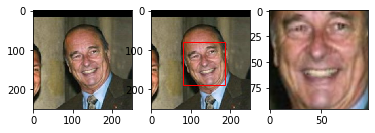

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Using random.randint(), chose an image number randomly in metadata
img_number = random.randint(0, len(metadata)-1) ## YOUR CODE HERE

# Load that image using the load_image() function that you have just written
jc_orig = load_image(metadata[img_number].image_path())## YOUR CODE HERE

# Detect face and return bounding box
bb = getLargestFaceBoundingBox(jc_orig)## YOUR CODE HERE

# Transform image using the face landmark indices for OUTER_EYES_AND_NOSE and crop image to FACE_IMG_SIZE x FACE_IMG_SIZE pixels
jc_aligned = align(96, jc_orig, bb, landmarkIndices= OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

### Possible improvements: 1 point
Run the test several times. You should find at least 2 ideas of improvements. Please state them (0.5 point by idea, you can find more than 2)

Notice that OpenFace is giving good results, but they are beaten by humans, by Google (DeepFace) and by Baidu, the chinese concurrent of Google:

![Texte alternatif…](http://bamos.github.io/data/2016-01-19/roc.png)

## Improvements Part 2

**First improvement** : We can use DeepFace Ensemble which is a deep learning facial recognition system created by a research group at Facebook.
It identifies human faces in digital images. It employs a nine-layer neural net with over 120 million connection weights and was trained on four million images uploaded by Facebook users


**Second improvement** : We can get a better DataSet to train, like giving more pictures of differents type of people.


##Face embedding: 8 points
After having extracted the face, we use a pre-trained CNN in order to "transform" the face image into a vector of 128 numbers "as representative as possible" from that face.

The idea here is as follows:
- Images from the same face will have similar vectors: these vectors will be neighbors, in terms of euclidian distance.
- Images from different faces will have dissimilar vectors: these vectors will be far away from eachother, in terms of euclidian distance.

![Texte alternatif…](http://bamos.github.io/data/2016-01-19/optimization-spheres.png)

Therefore, in order to recognize a face, the idea is as follows:
- Compute the vector corresponding to our image of a face
- Compute the vectors of all the faces in our dataset
- Check if the vectors of one known person in the dataset are "near enough" to the vector of the person that we want to identify



###CNN architecture: 6 points

The CNN architecture used here is a variant of the inception architecture [[2]](https://arxiv.org/abs/1409.4842). More precisely, it is a variant of the NN4 architecture described in [[1]](https://arxiv.org/abs/1503.03832) and identified as [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) model in the OpenFace project. This notebook uses a Keras implementation of that model whose definition was taken from the [Keras-OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace) project. The most important here is the top layer, which is referred to as the *embedding layer* from which the 128-dimensional embedding vectors can be obtained. 

![Texte alternatif…](https://github.com/krasserm/face-recognition/blob/master/model.png?raw=true)

In [ ]:
import tensorflow as tf
## This function defines a layer that does not exist in Keras, which is needed in the Inception neural network.
def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)


In [ ]:

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D


Using TensorFlow backend.


Let's begin by the first layers. (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_x.png) if you need to zoom on the image):

<img src="http://www.eyrignoux.com.fr/coursIA/deepLearning/model_x.png" width="300">

**Beware of the name of each layer: they will be used when loading the weights of the pretrained network, so don't make mistakes !**


In [ ]:

# Here we use the functional API of Keras, see an example here: https://keras.io/getting-started/functional-api-guide/
def create_first_layers():
    myInput = Input(shape=(96, 96, 3))## YOUR CODE HERE: the input layer must accept batches of RGB images of size FACE_IMG_SIZE x FACE_IMG_SIZE pixels

    x = ZeroPadding2D(padding=(3, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x) ## YOUR CODE HERE: MaxPooling2D layer, pool_size=3, strides=2
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)## YOUR CODE HERE: Conv2D layer, 64 kernels of size 1x1, name='conv2'
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='bn2'
    x = Activation('relu')(x)## YOUR CODE HERE: relu layer
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)## YOUR CODE HERE: Conv2D layer, 192 kernels of size 3x3, name='conv3'
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='bn3'
    x = Activation('relu')(x)## YOUR CODE HERE: relu layer
    x = Lambda(LRN2D, name='lrn_2')(x)
    # The 2 layers blow are missing on the image, but they are mandatory in the architecture (you can see them on the image of the full architecture)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)## YOUR CODE HERE: MaxPooling2D layer, pool_size=3, strides=2

    return myInput, x

Our first inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3a.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3a.png)

In [ ]:
def create_inception_3a(x):
  
    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)## YOUR CODE HERE: conv2D layer, 96 filters of size 1x1, name='inception_3a_3x3_conv1'
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1'
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)## YOUR CODE HERE: relu layer
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)## YOUR CODE HERE: conv2D layer, 128 filters of size 3x3, name='inception_3a_3x3_conv2')
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2'
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)## YOUR CODE HERE: relu layer

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)## YOUR CODE HERE: conv2D layer, 16 filters of size 1x1, name='inception_3a_5x5_conv1', TAKING x AS INPUT
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1'
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)## YOUR CODE HERE: relu layer
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)## YOUR CODE HERE: conv2D layer, 32 filters of size 5x5, name='inception_3a_5x5_conv2'
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2'
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)## YOUR CODE HERE: relu layer

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)## YOUR CODE HERE: MaxPooling2D, pool_size=3, strides=2, TAKING x AS INPUT
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)## YOUR CODE HERE: conv2D layer, 32 filters of size 1x1, name='inception_3a_pool_conv'
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_pool_bn'
    inception_3a_pool = Activation('relu')(inception_3a_pool)## YOUR CODE HERE: relu layer
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)## YOUR CODE HERE: conv2D layer, 64 filters of size 1x1, name='inception_3a_1x1_conv', TAKING x AS INPUT
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)## YOUR CODE HERE: BatchNormalization layer, axis=3, epsilon=0.00001, name='inception_3a_1x1_bn'
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1) ## YOUR CODE HERE: relu layer

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    return inception_3a
  

Our 2nd inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3b.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3b.png)

In [ ]:
def create_inception_3b(inception_3a):
    # Inception3b: reproduce Inception3a, but for the names of the layers: replace 'a' by 'b' in the names.
    # Example: the name 'inception_3a_3x3_conv1' becomes 'inception_3b_3x3_conv1'
    # BE CAREFUL: the MaxPooling2D of inception_3a_pool must be replaced by an AveragePooling2D in inception_3b_pool
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    return inception_3b

Our 3rd inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3c.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_3c.png)

In [ ]:
def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

In [ ]:
def create_inception_3c(inception_3b):
  
    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    return inception_3c

Our 4th inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_4a.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_4a.png)

In [ ]:
def create_inception_4a(inception_3c):
    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    return inception_4a

Our 5th inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_4e.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_4e.png)

In [ ]:
def create_inception_4e(inception_4a):
    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    return inception_4e

Our 6th inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_5a.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_5a.png)

In [ ]:
def create_inception_5a(inception_4e):
    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    return inception_5a

Our 7th inception layer (click on the [link](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_5b.png) if you need to zoom on the image):
![Texte alternatif…](http://www.eyrignoux.com.fr/coursIA/deepLearning/model_inception_5b.png)

In [ ]:
def create_inception_5b(inception_5a):
    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    return inception_5b

In [ ]:

from keras.models import Model
from keras import backend as K

def create_model():
  
    myInput, x = create_first_layers()
    
    inception_3a = create_inception_3a(x)
    inception_3b = create_inception_3b(inception_3a)
    inception_3c = create_inception_3c(inception_3b)
    inception_4a = create_inception_4a(inception_3c)
    inception_4e = create_inception_4e(inception_4a)
    inception_5a = create_inception_5a(inception_4e)
    inception_5b = create_inception_5b(inception_5a)
    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)
  

In [ ]:

nn4_small2 = create_model()

###CNN pre-training
Training the CNN from scratch is very expensive and requires huge datasets to achieve good generalization performance. For example, [[1]](https://arxiv.org/abs/1503.03832) uses a dataset of 200M images consisting of about 8M identities. 

Therefore, we WON'T train our CNN in this project. The next section *demonstrates* how this training is done on a toy dataset.

Later on, when we will want to actually identify faces, we will load pre-trained weights into our CNN, which were trained during several days or weeks on huge datasets.

###Triplet loss: 1 point


Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))
in_p = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))
in_n = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

During training, it is important to select triplets whose positive pairs $(x^a_i, x^p_i)$ and negative pairs $(x^a_i, x^n_i)$ are hard to discriminate i.e. their distance difference in embedding space should be less than margin $\alpha$, otherwise, the network is unable to learn a useful embedding. Therefore, each training iteration should select a new batch of triplets based on the embeddings learned in the previous iteration. Assuming that a generator returned from a `triplet_generator()` call can generate triplets under these constraints, the network can be trained with:

In [ ]:

def triplet_generator():
    ''' Dummy triplet generator for API usage demo only.
    Will be replaced by a version that uses real image data later.
    :return: a batch of (anchor, positive, negative) triplets
    '''
    while True:
        a_batch = np.random.rand(4, 96, 96, 3)
        p_batch = np.random.rand(4, 96, 96, 3)
        n_batch = np.random.rand(4, 96, 96, 3)
        yield [a_batch , p_batch, n_batch], None

In [ ]:

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

## YOUR CODE HERE: compile the model nn4_small2_train with loss=None and 'adam' as the optimizer
nn4_small2_train.compile(loss=None, optimizer='adam')

## YOUR CODE HERE: call nn4_small2_train.fit_generator() on your fake generator, in order to train the model for 10 epochs, with 100 steps_per_epoch
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)
# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
100/100 [==============================] - 33s 328ms/step - loss: 0.8240
Epoch 2/10
100/100 [==============================] - 9s 93ms/step - loss: 0.8097
Epoch 3/10
100/100 [==============================] - 9s 93ms/step - loss: 0.8018
Epoch 4/10
100/100 [==============================] - 9s 94ms/step - loss: 0.8007
Epoch 5/10
100/100 [==============================] - 9s 94ms/step - loss: 0.8005
Epoch 6/10
100/100 [==============================] - 9s 94ms/step - loss: 0.8005
Epoch 7/10
100/100 [==============================] - 9s 93ms/step - loss: 0.8005
Epoch 8/10
100/100 [==============================] - 10s 95ms/step - loss: 0.7996
Epoch 9/10
100/100 [==============================] - 10s 95ms/step - loss: 0.8003
Epoch 10/10
100/100 [==============================] - 9s 94ms/step - loss: 0.7993


###Load pre-trained weights: 1 point

The OpenFace project provides [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) that were trained with the public face recognition datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and [CASIA-WebFace](http://arxiv.org/abs/1411.7923). The Keras-OpenFace project converted the weights of the pre-trained nn4.small2.v1 model to [CSV files](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights) which were then [converted here](face-recognition-convert.ipynb) to a binary format that can be loaded by Keras with `load_weights`:

In [ ]:
!mkdir weights
!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/nn4.small2.v1.h5 -P weights

--2020-01-06 11:17:47--  http://www.eyrignoux.com.fr/coursIA/deepLearning/nn4.small2.v1.h5
Resolving www.eyrignoux.com.fr (www.eyrignoux.com.fr)... 62.210.16.62
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eyrignoux.com.fr/coursIA/deepLearning/nn4.small2.v1.h5 [following]
--2020-01-06 11:17:47--  https://www.eyrignoux.com.fr/coursIA/deepLearning/nn4.small2.v1.h5
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15300744 (15M) [application/octet-stream]
Saving to: ‘weights/nn4.small2.v1.h5’

nn4.small2.v1.h5    100%[===================>]  14.59M  35.0MB/s    in 0.4s    

2020-01-06 11:17:47 (35.0 MB/s) - ‘weights/nn4.small2.v1.h5’ saved [15300744/15300744]



In [ ]:
nn4_small2_pretrained = create_model()
## YOUR CODE HERE: use the function load_weights() in order to load the weights from 'weights/nn4.small2.v1.h5' into nn4_small2_pretrained
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

##Face recognition: 5 points
Our CNN is initialized with weights trained with the public face recognition datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and [CASIA-WebFace](http://arxiv.org/abs/1411.7923), during several days or weeks. Now it is able to compute similar embedding vectors for similar faces, and dissimilar embedding vectors for dissimilar faces, because it learnt to differentiate faces very accurately.

Now, let's suppose that you want to identify only a small set of people, let's say 10 persons: for example yourself, some of your friends, and a few members of your familly. Let's suppose that you have around 10 images per people that you want to identify. It makes a dataset of 10x10 = 100 images.

Here is what you have to do:
- Using the CNN, compute the embedding vector of each of your 100 images
- If the CNN works, the embedding vectors of the images of one person should be close to eachother in terms of euclidian distance, and the embedding vectors of other persons should be far away
- You simply have to evaluate the "average size" of a group of vectors representing one person. 
- When you want to identify a new face, you have to compute its embedding vector using the CNN, and check if it is "near enough" to the embeddings of the persons that you have in your dataset (ie. below the threshold that you just computed above).

![Texte alternatif…](https://github.com/cmusatyalab/openface/blob/master/images/sphere-demo/screenshot.png?raw=true)

On the image above, the CNN computes an embedding vector for both faces. As these vectors are "far away" from each other, the algorithm understands that they belong to 2 different persons. Same idea for the animation below, with 3 persons.

![Texte alternatif…](https://github.com/cmusatyalab/openface/blob/master/images/sphere-demo/demo.gif?raw=true)

###Compute embedding vectors for all the images of our dataset: 1 point

In [ ]:
embedded = np.zeros((metadata.shape[0], EMBEDDING_VECTOR_SIZE))

## When working on face detection, we used a small dataset of 100 images: 10 images for 10 celebrities.
## We stored it into a variable called metadata
## Iterate over this dataset and compute the embedding vector for each image of the dataset
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img_aligned = align(96, img, getLargestFaceBoundingBox(img), landmarkIndices= OUTER_EYES_AND_NOSE)
    # scale RGB values to interval [0,1]
    img_aligned = (img_aligned / 255.).astype(np.float32) ## YOUR CODE HERE: the usual way to normalize an image. The result must be a numpy array of type np.float32
    # obtain embedding vector for image
    # 1) img_aligned is an image of shape (FACE_IMG_SIZE, FACE_IMG_SIZE, 3), but your CNN is waiting for a list of images (also called a batch of images).
    #    Hint: you might want to add a dimension to your image in order to create that list, on which axis ?
    # 2) call nn4_small2_pretrained.predict(...) in order to compute the embeddings for your list of images.
    #    Nb: you need only the embeddings for the first element of the batch (which contains only one element, however !)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img_aligned, axis=0))[0]

Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

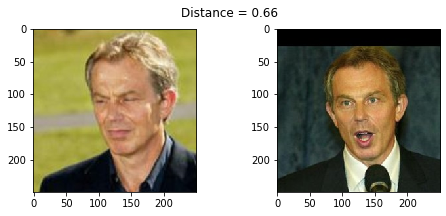

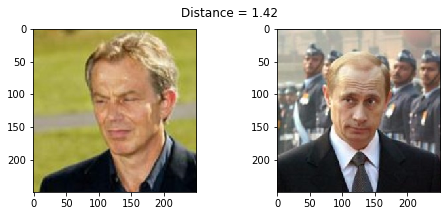

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))## YOUR CODE HERE: use np.sum() and np.square() in order to compute the euclidian distance between the vectors emb1 and emb2

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

# As we have 10 images per person in our dataset, we know that images 2 and 3 belong to the same person
show_pair(2, 3)
# ... and that images 2 and 13 belong to different people
show_pair(2, 12)

As expected, the distance between the two images of the same person is smaller than the distance between images of different persons (0.30 < 1.12). But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

###Face recognition by Distance threshold: 1 point

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

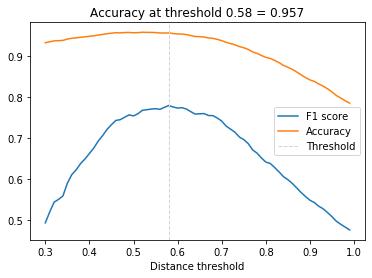

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        dist = distance(embedded[i], embedded[j])## YOUR CODE HERE: compute the distance between the embedding vectors i and j
        distances.append(dist)
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)## YOUR CODE HERE: use np.arange() in order to make a list of possible thresholds between 0.3 and 1.0, by steps of 0.01

# For each possible threshold:
# distances < threshold returns a vector of booleans: for each dist in distances, the boolean says if the dist is below the threshold
# f1_score(identical, distances < threshold) returns the f1_score between the "ground truth" (the vector called 'identical') and the results
#    found by using the specific threshold called 'threshold'
f1_scores = [f1_score(identical, distances < t) for t in thresholds]## YOUR CODE HERE: compute the F1 score for each element of thresholds
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]## YOUR CODE HERE: compute the accuracy score for each element of thresholds

opt_idx = np.argmax(f1_scores)## YOUR CODE HERE: use np.argmax() in order to get the indice of the best threshold 
          ## (ie. the one that corresponds to the highest f1_score - ie. the indice of the biggest element of f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

The face verification accuracy at $\tau$ = 0.56 is 95.7%. This is not bad given a baseline of 89% for a classifier that always predicts *different identity* (there are 980 pos. pairs and 8821 neg. pairs) but since nn4.small2.v1 is a relatively small model it is still less than what can be achieved by state-of-the-art models (> 99%). 

The following two histograms show the distance distributions of positive and negative pairs and the location of the decision boundary. There is a clear separation of these distributions which explains the discriminative performance of the network. One can also spot some strong outliers in the positive pairs class but these are not further analyzed here.

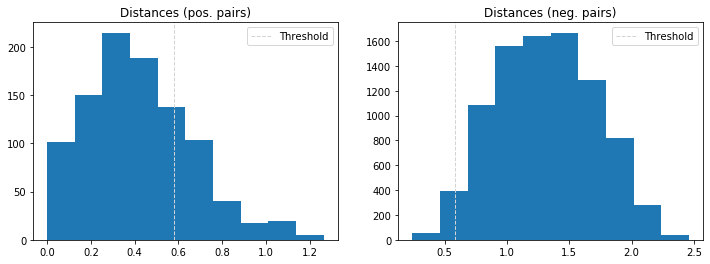

In [ ]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label *unknown* otherwise. This procedure can also scale to large databases as it can be easily parallelized. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

### Face recognition with KNN or SVM: 2 points



A more robust approach is to label the input using the top $k$ scoring entries in the database which is essentially [KNN classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with a Euclidean distance metric. Alternatively, a linear [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine) (SVM) can be trained with the database entries and used to classify i.e. identify new inputs. For training these classifiers we use 50% of the dataset, for evaluation the other 50%.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)
## YOUR CODE HERE: use LabelEncoder() in order to give numeric values to the targets (ie. the names of the persons of the dataset)
y = encoder.transform(targets)# Numeric values of the names of the persons in the dataset

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')## YOUR CODE HERE: instanciate a KNeighborsClassifier, with n_neighbors=1
      ## Select metric='euclidean', since we worked with that formula until now, when computing distances between vectors.
svc = LinearSVC()## YOUR CODE HERE: instanciate a LinearSVC

## YOUR CODE HERE: fit your knn and your svc on the training set, using X_train and y_train
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))## YOUR CODE HERE: compute the accuracy_score of your knn on the test set
acc_svc = accuracy_score(y_test, svc.predict(X_test)) ## YOUR CODE HERE: compute the accuracy_score of your svc on the test set

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.96, SVM accuracy = 0.96


The KNN classifier achieves an accuracy of 96% on the test set, the SVM classifier 98%. Let's use the SVM classifier to illustrate face recognition on a single example.

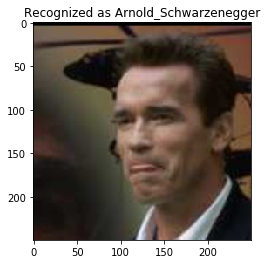

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

# Using random.randint(), chose an image number randomly in X_test
example_idx = random.randint(0, 50)## YOUR CODE HERE

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

Seems reasonable :-) Classification results should actually be checked whether (a subset of) the database entries of the predicted identity have a distance less than $\tau$, otherwise one should assign an *unknown* label. This step is skipped here but can be easily added.



### Dataset visualization

To embed the dataset into 2D space for displaying identity clusters, [t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

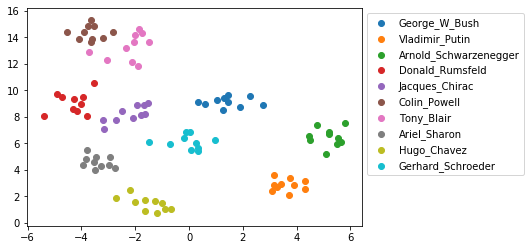

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

###Possible improvements: 1 point
Find at least 1 possible improvement on what we did in that section: 0.5 point

Try it and check if it improves the results: 0.5 point

# Improvement Part 2

**Improvement** : as you told us, we can improve the model by excluding the last line of neurone with all faces to allowed him to recongnize two faces with the numbers that will conrrespond to different part of the face.

##Try with your own dataset: 2 points
Create your own dataset (you, your friends, other celebrities...), use it in place of ours, and see if it works.

If it does not work, do you have any idea why ? This question is the most interesting of all, since you are now using "true data", not a curated dataset.

PREPARING DATA

In [ ]:
!unzip images2.zip -d 'images2'

unzip:  cannot find or open images2.zip, images2.zip.zip or images2.zip.ZIP.


In [ ]:
metadata2 = load_metadata('images2/images2')

GET RANDOM IMAGE OF CELEBRITY FROM DATASET

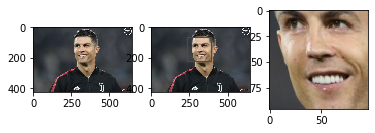

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Using random.randint(), chose an image number randomly in metadata2
img_number = random.randint(0, len(metadata2)-1) ## YOUR CODE HERE

# Load that image using the load_image() function that you have just written
jc_orig = load_image(metadata2[img_number].image_path())## YOUR CODE HERE

# Detect face and return bounding box
bb = getLargestFaceBoundingBox(jc_orig)## YOUR CODE HERE

# Transform image using the face landmark indices for OUTER_EYES_AND_NOSE and crop image to FACE_IMG_SIZE x FACE_IMG_SIZE pixels
jc_aligned = align(96, jc_orig, bb, landmarkIndices= OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

STEP :Compute embedding vectors for all the images of our dataset

In [ ]:
embedded2 = np.zeros((metadata2.shape[0], EMBEDDING_VECTOR_SIZE))

## When working on face detection, we used a small dataset of 42 images: 6 images for 7 celebrities.
## We stored it into a variable called metadata2
## Iterate over this dataset and compute the embedding vector for each image of the dataset
for i, m in enumerate(metadata2):
    img = load_image(m.image_path())
    img_aligned = align(96, img, getLargestFaceBoundingBox(img), landmarkIndices= OUTER_EYES_AND_NOSE)
    # scale RGB values to interval [0,1]
    img_aligned = (img_aligned / 255.).astype(np.float32) ## YOUR CODE HERE: the usual way to normalize an image. The result must be a numpy array of type np.float32
    # obtain embedding vector for image
    # 1) img_aligned is an image of shape (FACE_IMG_SIZE, FACE_IMG_SIZE, 3), but your CNN is waiting for a list of images (also called a batch of images).
    #    Hint: you might want to add a dimension to your image in order to create that list, on which axis ?
    # 2) call nn4_small2_pretrained.predict(...) in order to compute the embeddings for your list of images.
    #    Nb: you need only the embeddings for the first element of the batch (which contains only one element, however !)
    embedded2[i] = nn4_small2_pretrained.predict(np.expand_dims(img_aligned, axis=0))[0]

the resultat FOR 2 IMAGES


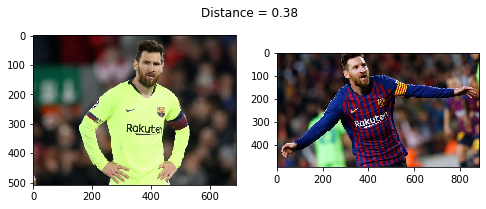

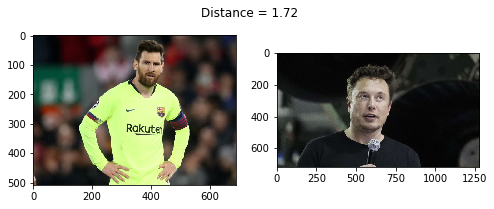

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))## YOUR CODE HERE: use np.sum() and np.square() in order to compute the euclidian distance between the vectors emb1 and emb2

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded2[idx1], embedded2[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata2[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata2[idx2].image_path()));    

# As we have 6 images per person in our dataset, we know that images 2 and 3 belong to the same person
show_pair(2, 3)
# ... and that images 2 and 13 belong to different people
show_pair(2, 12)

FACE RECOGNITION BY DISTANCE THRESHOLD

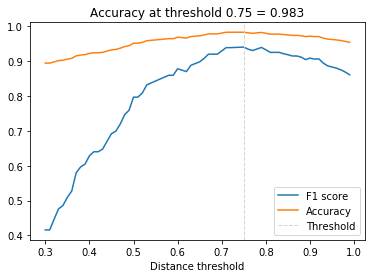

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances2 = [] # squared L2 distance between pairs
identical2 = [] # 1 if same identity, 0 otherwise

num = len(metadata2)

for i in range(num - 1):
    for j in range(1, num):
        dist = distance(embedded2[i], embedded2[j])## YOUR CODE HERE: compute the distance between the embedding vectors i and j
        distances2.append(dist)
        identical2.append(1 if metadata2[i].name == metadata2[j].name else 0)
        
distances2 = np.array(distances2)
identical2 = np.array(identical2)

thresholds2 = np.arange(0.3, 1.0, 0.01)## YOUR CODE HERE: use np.arange() in order to make a list of possible thresholds2 between 0.3 and 1.0, by steps of 0.01

# For each possible threshold:
# distances2 < threshold returns a vector of booleans: for each dist in distances, the boolean says if the dist is below the threshold
# f1_score(identical2, distances2 < threshold) returns the f1_score between the "ground truth" (the vector called 'identical2') and the results
#    found by using the specific threshold called 'threshold'
f1_scores = [f1_score(identical2, distances2 < t) for t in thresholds2]## YOUR CODE HERE: compute the F1 score for each element of thresholds2
acc_scores = [accuracy_score(identical2, distances2 < t) for t in thresholds2]## YOUR CODE HERE: compute the accuracy score for each element of thresholds2

opt_idx = np.argmax(f1_scores)## YOUR CODE HERE: use np.argmax() in order to get the indice of the best threshold 
          ## (ie. the one that corresponds to the highest f1_score - ie. the indice of the biggest element of f1_scores)
# Threshold at maximal F1 score
opt_tau2 = thresholds2[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical2, distances2 < opt_tau2)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds2, f1_scores, label='F1 score');
plt.plot(thresholds2, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau2, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau2:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

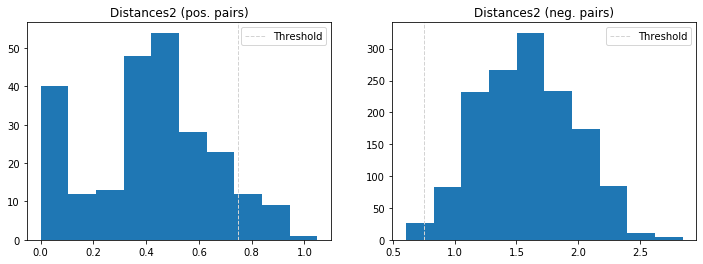

In [ ]:
dist_pos = distances2[identical2 == 1]
dist_neg = distances2[identical2 == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau2, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances2 (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau2, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances2 (neg. pairs)')
plt.legend();

PREPARING MODEL FOR FACE RECOGNITION WITH KNN OR SVM

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata2])

encoder = LabelEncoder()
encoder.fit(targets)
## YOUR CODE HERE: use LabelEncoder() in order to give numeric values to the targets (ie. the names of the persons of the dataset)
y = encoder.transform(targets)# Numeric values of the names of the persons in the dataset

train_idx = np.arange(metadata2.shape[0]) % 2 != 0
test_idx = np.arange(metadata2.shape[0]) % 2 == 0

# 21 examples of 7 identities (3 examples each)
X_train = embedded2[train_idx]
# 21 examples of 7 identities (3 examples each)
X_test = embedded2[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')## YOUR CODE HERE: instanciate a KNeighborsClassifier, with n_neighbors=1
      ## Select metric='euclidean', since we worked with that formula until now, when computing distances2 between vectors.
svc = LinearSVC()## YOUR CODE HERE: instanciate a LinearSVC

## YOUR CODE HERE: fit your knn and your svc on the training set, using X_train and y_train
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))## YOUR CODE HERE: compute the accuracy_score of your knn on the test set
acc_svc = accuracy_score(y_test, svc.predict(X_test)) ## YOUR CODE HERE: compute the accuracy_score of your svc on the test set

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 1.0, SVM accuracy = 1.0


 the SVM classifier to illustrate face recognition on a single example.

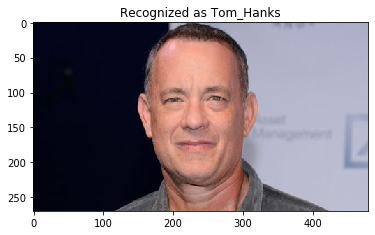

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

# Using random.randint(), chose an image number randomly in X_test
example_idx = random.randint(0, 20)## YOUR CODE HERE

example_image = load_image(metadata2[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded2[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

DATA VIZ

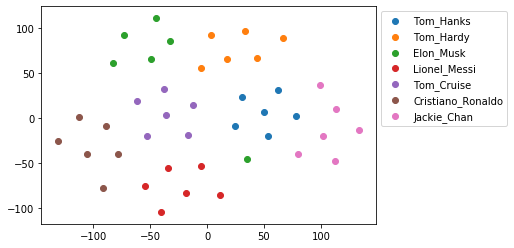

In [ ]:
from sklearn.manifold import TSNE

X_embedded2 = TSNE(n_components=2).fit_transform(embedded2)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded2[idx, 0], X_embedded2[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

### References

- [1] [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)
- [2] [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)